# Rentrenamiento del modelo CNN-LSTM

En este notebbook se rentrenará el segundo mejor modelo, que en la primera vez de la etapa de entrenamiento se logró un 85.82% de accuracy. Cabe precisar, que fue necesario rentrenar los modelos para poder generar los subconjuntos de las clases predichas con el conjunto Testing a fin de poder aplicar el efecto causal al conjunto de registros predichos como clase 0 y al conjunto de registros preidchos como clase 1.

## Instalación de la librería keras-preprocessing

In [1]:
!pip install keras_preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.5 MB/s eta 0:00:00


## Importación de librerías

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
import sys
import csv
import re
from tqdm.notebook import tqdm
import sys
import csv
import io
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Fijar semillas

Con la finalidad de mitigar posibles sesgos fijamos las semillas antes de cualquier operación que involucre aleatoriedad (preprocesamiento por ejemplo con el tokenizador, entrenamiento del modelo específicamente en la inicialización de pesos). Esto permitirá que cualquier aleatoriedad durante el proceso sea controlado y reproducible.

In [3]:
import random
import tensorflow as tf

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

## Cargar los conjuntos de datos fijos

### Corpus completo (4014 registros)

In [4]:
#Cargar el conjunto training con atributos recuperados
# Training_3130.xlsx'
from google.colab import files
uploaded = files.upload()

Saving sgc_4014.xlsx to sgc_4014.xlsx


In [5]:
#Asignar a una variable el contenido del conjunto de datos
sgc = io.BytesIO(uploaded['sgc_4014.xlsx'])
df_sgc4014 = pd.read_excel(sgc)
df_sgc4014.head()

,Tweet_Checked,Id,Fecha,Clase_Argumento,Word_quantity,Long_text
0,elecciones2021 apurímac respaldo a candidato p...,2882,2021-04-11,1,15,0
1,elecciones2021 pueblo libre adultos mayores aú...,1795,2021-06-06,1,35,1
2,elecciones2021 si fuiste elegido miembro de me...,3113,2021-04-09,1,23,0
3,elecciones2021 es importante mantenerte inform...,3305,2021-04-05,1,36,1
4,nuestros partidos políticos están tan dividido...,2878,2021-04-12,1,32,1


In [6]:
df_sgc4014.shape

(4014, 6)

In [7]:
df_sgc4014.Clase_Argumento.value_counts()

,count
Clase_Argumento,
0,2057
1,1957


### Conjunto Training (3130 registros)

In [8]:
#Cargar el conjunto training con atributos recuperados
# Training_3130.xlsx'
from google.colab import files
uploaded = files.upload()

Saving Training_3130.xlsx to Training_3130.xlsx


In [9]:
#Asignar a una variable el contenido del conjunto de datos
training = io.BytesIO(uploaded['Training_3130.xlsx'])
df_training = pd.read_excel(training)
df_training.head()

,Tweet_Checked,Id,Fecha,Clase_Argumento,Word_quantity,Long_text
0,elecciones2021 apurímac respaldo a candidato p...,2882,2021-04-11,1,15,0
1,elecciones2021 pueblo libre adultos mayores aú...,1795,2021-06-06,1,35,1
2,elecciones2021 si fuiste elegido miembro de me...,3113,2021-04-09,1,23,0
3,elecciones2021 es importante mantenerte inform...,3305,2021-04-05,1,36,1
4,nuestros partidos políticos están tan dividido...,2878,2021-04-12,1,32,1


In [10]:
df_training.shape

(3130, 6)

In [11]:
df_training.Clase_Argumento.value_counts()

,count
Clase_Argumento,
0,1604
1,1526


### Conjunto Validation (200 registros)

In [12]:
#Cargar el conjunto training con atributos recuperados
# Validation_200.xlsx'
from google.colab import files
uploaded = files.upload()

Saving Validation_200.xlsx to Validation_200.xlsx


In [13]:
#Asignar a una variable el contenido del conjunto de datos
validation = io.BytesIO(uploaded['Validation_200.xlsx'])
df_validation = pd.read_excel(validation)
df_validation.head()

,Tweet_Checked,Id,Fecha,Clase_Argumento,Word_quantity,Long_text
0,pedrocastillote estoy casi seguro q le ingresó...,1948,2021-12-17,1,46,1
1,paridad y alternancia desde defensoriaperu des...,465,2020-07-24,1,32,1
2,oficinas descentralizada de procesos electoral...,3202,2021-04-07,1,29,0
3,jurado nacional de elecciones registró 25 inci...,212,2020-11-29,1,16,0
4,video panorama elecciones2021 hernando de soto...,175,2020-12-07,1,14,0


In [14]:
df_validation.shape

(200, 6)

In [15]:
df_validation.Clase_Argumento.value_counts()

,count
Clase_Argumento,
0,102
1,98


### Conjunto Testing (684 registros)

In [16]:
#Cargar el conjunto testing con atributos recuperados
# Testing_684.xlsx'
from google.colab import files
uploaded = files.upload()

Saving Testing_684.xlsx to Testing_684.xlsx


In [17]:
#Asignar a una variable el contenido del conjunto de datos
testing = io.BytesIO(uploaded['Testing_684.xlsx'])
df_testing = pd.read_excel(testing)
df_testing.head()

,Tweet_Checked,Id,Fecha,Clase_Argumento,Word_quantity,Long_text
0,lima sur desde defensoriaperu demandamos respe...,191,2020-12-03,1,29,0
1,elecciones2021 el 10 de febrero es la fecha lí...,1122,2021-01-02,1,20,0
2,onpeinforma a partir de ahora compartiremos en...,2103,2021-04-13,1,28,0
3,último los titulares del jne la onpeoficial y ...,3639,2021-03-24,1,27,0
4,elecciones2021 lescano dice que sube en encues...,1228,2021-03-01,1,14,0


In [18]:
df_testing.shape

(684, 6)

In [19]:
df_testing.Clase_Argumento.value_counts()

,count
Clase_Argumento,
0,351
1,333


### Gráficamente: Distribución de los tres subconjuntos

#### Conjunto Training

###### Distribution of training data #####


<Axes: ylabel='count'>

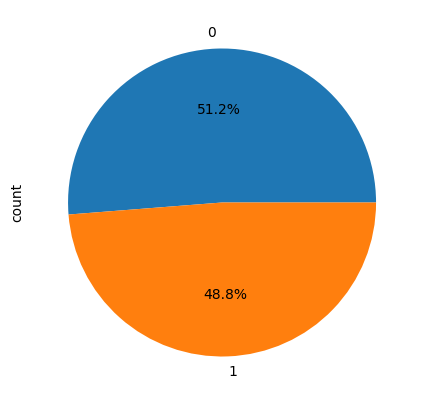

In [20]:
import matplotlib.pyplot as plt

print("###### Distribution of training data #####")
fig, ax = plt.subplots(1, 1, figsize=(5,5))
df_training['Clase_Argumento'].value_counts().plot.pie(autopct = '%1.1f%%')#, labels=labels)

#### Conjunto Validation

###### Distribution of validation data #####


<Axes: ylabel='count'>

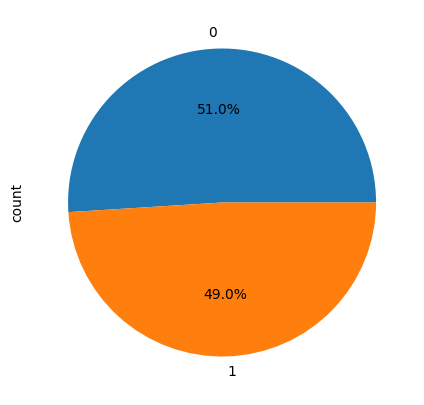

In [21]:
print("###### Distribution of validation data #####")
fig, ax = plt.subplots(1, 1, figsize=(5,5))
df_validation['Clase_Argumento'].value_counts().plot.pie(autopct = '%1.1f%%')#, labels=labels)

#### Conjunto Testing

###### Distribution of testing data #####


<Axes: ylabel='count'>

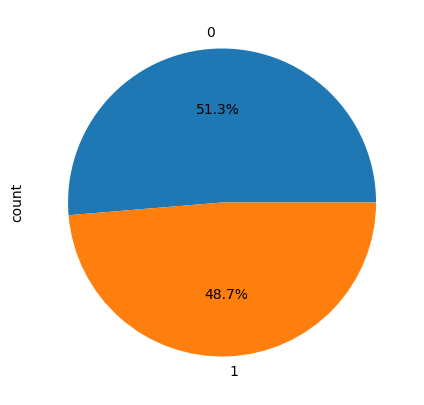

In [22]:
print("###### Distribution of testing data #####")
fig, ax = plt.subplots(1, 1, figsize=(5,5))
df_testing['Clase_Argumento'].value_counts().plot.pie(autopct = '%1.1f%%')#, labels=labels)

## Vectorización de los datos

### Inicializamos los parámetros globales

In [23]:
max_nb_words = 60000
max_features = 11000 #Máximo número de palabras que formaran parte del diccionario
maxlen = 500 #Nro de tokens a partir del cual crearemos la secuencia del tweet
emb_dim = 200 #Tamaño del vector embedding

### Inicializamos el tokenizador para todo el corpus

In [24]:
tokenizer = Tokenizer(num_words=max_nb_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_sgc4014['Tweet_Checked'].values)# tokenizer on whole training, testing and validation data
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9984 unique tokens.


### Convertir a secuencias y aplicar padding

#### Al atributo "Tweet_Checked"

In [25]:
train_sequences = tokenizer.texts_to_sequences(df_training['Tweet_Checked'].values)
train_padded = pad_sequences(train_sequences, maxlen=maxlen)
print('Shape del tensor', train_padded.shape)

test_sequences = tokenizer.texts_to_sequences(df_testing['Tweet_Checked'].values)
test_padded = pad_sequences(test_sequences, maxlen=maxlen)
print('Shape del tensor', test_padded.shape)

val_sequences = tokenizer.texts_to_sequences(df_validation['Tweet_Checked'].values)
val_padded = pad_sequences(val_sequences, maxlen=maxlen)
print('Shape del tensor', val_padded.shape)

Shape del tensor (3130, 500)
Shape del tensor (684, 500)
Shape del tensor (200, 500)


#### A la clase "Clase_Argumento"

El usar pd.get_dummies fue para dar el shape adecuada a la salida de la clase y poder usarla sin problemas durante el entrenamiento del modelo CNN-LSTM.

In [26]:
Y_train = pd.get_dummies(df_training['Clase_Argumento']).values
print('Shape del tensor Y_train', Y_train.shape)

Y_test = pd.get_dummies(df_testing['Clase_Argumento']).values
print('Shape del tensor Y_test', Y_test.shape)

Y_val = pd.get_dummies(df_validation['Clase_Argumento']).values
print('Shape del tensor Y_val', Y_val.shape)

Shape del tensor Y_train (3130, 2)
Shape del tensor Y_test (684, 2)
Shape del tensor Y_val (200, 2)


## Cargar los embedding con Glove de SBWC

Vista que este es un rentrenamiento del segundo mejor modelo, se usará el embedding que se uso en marzo del 2023 a fin de asegurar su replicación sin sesgos o variaciones que podrían eventualmente cambiar los resultados por lo que se cargará desde mi google drive.

In [27]:
#Para conectar a mi Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [28]:
embedding_vectors = {}

with open('/content/gdrive/MyDrive/Tesis Doctoral PUCP/FASE II_CAUSAL METHODOLOGY/glove.twitter.27B.200d.txt', 'r', encoding='utf-8') as file:
  for row in file:
    values = row.split(' ')
    word = values[0]
    weights = np.asarray([float(val) for val in values[1:]])
    embedding_vectors[word] = weights

print(f"Tamaño del vocabulario en Glove: {len(embedding_vectors)}")

Tamaño del vocabulario en Glove: 1193515


In [29]:
#initialize the embedding_matrix with zeros: Es necesario correrlo para que se ejecute la funcion "pretrained_embedding_layer"
emb_dim = 200 #200 es la dimensión del vector embedding SBWC
if max_nb_words is not None:
    vocab_len = max_nb_words
else:
    vocab_len = len(word_index)+1

embedding_matrix = np.zeros((vocab_len, emb_dim))

oov_count = 0
oov_words = []
for word, idx in word_index.items():
    if idx < vocab_len:
        embedding_vector = embedding_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

        else:
            oov_count += 1
            oov_words.append(word)
#Check some of the out of vocabulary words
print(f'A few out of valubulary words: {oov_words[0:5]}')
print(f'{oov_count} out of {vocab_len} words were OOV.')

A few out of valubulary words: ['elecciones2021', 'nuevaconstitucion', '11', 'onpeoficial', 'jneperu']
1761 out of 60000 words were OOV.


Vemos que 1761 palabras se encuentran como OOV de un total de 60,000 por lo que representa un porcentaje pequeño, aproximadamente 2,9% siendo aceptable para la mayoría de trabajos de NLP. Asimismo, los modelos CNN, CNN-LSTM, CNN-LSTM-MLP suelen mejorar adecudamente términos OOV debido a su capacidad de generalización la cual fue evidenciadad durante la primera vez que se entrenaron los modelos DL en marzo del 2023.

## Implementación del modelo CNN-LSTM

In [30]:
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Flatten
from keras.layers import Dropout, Input
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D

from sklearn.metrics import confusion_matrix
from keras import initializers, layers, models, regularizers, constraints, optimizers
from keras.utils import to_categorical

#from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam
import math

In [31]:
##Global variables
batch_size = 256 #Se obtiene mejores resultados con este valor de batch_size
epochs  = 25

#### Función: Detener el entrenamiento del modelo

En caso el 'loss' no disminuya luego de mínimo 5 epochs sucesivos

In [32]:
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from keras.callbacks import Callback

detener = EarlyStopping(monitor='val_loss', mode='min', verbose=5, patience=5)

#### Entrenamiento del modelo CNN-LSTM

In [51]:
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

dict_characters = {0: '0', 1: '1', 2: '2',
        3: '3', 4: '4', 5: '5', 6: '6', 7:'7',
        8: '8', 9: '9'}

from matplotlib import pyplot as plt
import math
from keras.callbacks import LambdaCallback
#import keras.backend as K
import tensorflow.keras.backend as k

class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """
    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = k.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if math.isnan(loss) or loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        k.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1):
        num_batches = epochs * x_train.shape[0] / batch_size
        self.lr_mult = (end_lr / start_lr) ** (1 / num_batches)

        # Save weights into a file *********************************************************************************************************************
        self.model.save_weights('.weights.h5')

        # Remember the original learning rate
        original_lr = k.get_value(self.model.optimizer) ###############################################################################################

        # Set the initial learning rate
        k.set_value(self.model.optimizer, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                        batch_size=batch_size, epochs=epochs,
                        callbacks=[callback])

        # Restore the weights to the state before model fitting *****************************************************************************************
        self.model.load_weights('.weights.h5')

        # Restore the original learning rate **********************************************************************************************************
        k.set_value(self.model.optimizer, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale('log')

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivative = (self.losses[i] - self.losses[i - sma]) / sma
            derivatives.append(derivative)

        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], derivatives[n_skip_beginning:-n_skip_end])
        plt.xscale('log')
        plt.ylim(y_lim)

In [52]:
def determineLearningRate(xtrain,ytrain,xval,yval):
    batch_size = 256
    num_classes = 2
    epochs = 5
    model = Sequential()
    model.add(Embedding(vocab_len, emb_dim, weights=[embedding_matrix]))
    model.add(layers.Conv1D(256, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(LSTM(256, return_sequences=True))
    model.add(layers.LSTM(256))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    lr_finder = LRFinder(model)
    lr_finder.find(xtrain,ytrain, start_lr=0.0000001, end_lr=100, batch_size=batch_size, epochs=5)
    lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)
    plt.show()
    return model

determineLearningRate(train_padded, Y_train, val_padded, Y_val)

AttributeError: 'Adam' object has no attribute 'dtype'

In [53]:
#Dado que no se pudo corregir la función del método LRFinder() entonces:
#Se trabajará con el mismo valor incializado para learning_rate durante la primera vez que se realizó el entrenamiento
learning_rate=0.001
def CNN_LSTM_model(embedding_matrix):
    emb_dim = embedding_matrix.shape[1]
    cnn_lstm_model = Sequential()
    cnn_lstm_model.add(Embedding(vocab_len, emb_dim, weights=[embedding_matrix]))
    cnn_lstm_model.add(layers.Conv1D(256, kernel_size=3, padding='same', activation='relu'))
    cnn_lstm_model.add(layers.MaxPooling1D(pool_size=2))
    cnn_lstm_model.add(LSTM(256, return_sequences=True))
    cnn_lstm_model.add(layers.LSTM(256))
    cnn_lstm_model.add(Dense(2, activation='softmax'))
    cnn_lstm_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    cnn_lstm_model.summary()
    return cnn_lstm_model

In [54]:
cnn_lstm_model = CNN_LSTM_model(embedding_matrix)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)             │ ?                           │      12,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_20 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,000,000 (45.78 MB)

 Trainable params: 12,000,000 (45.78 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
#Fit the CNN-LSTM model
history = cnn_lstm_model.fit(train_padded, np.asarray(Y_train), validation_data=(val_padded, np.asarray(Y_val)), batch_size = batch_size, epochs = epochs, callbacks=[detener])

Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 195s 14s/step - accuracy: 0.5740 - loss: 0.7328 - val_accuracy: 0.7300 - val_loss: 0.5241
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 183s 14s/step - accuracy: 0.7326 - loss: 0.5493 - val_accuracy: 0.8050 - val_loss: 0.4649
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 206s 14s/step - accuracy: 0.7878 - loss: 0.4602 - val_accuracy: 0.8000 - val_loss: 0.4397
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 197s 14s/step - accuracy: 0.8411 - loss: 0.3527 - val_accuracy: 0.8300 - val_loss: 0.3724
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 198s 14s/step - accuracy: 0.9000 - loss: 0.2467 - val_accuracy: 0.8550 - val_loss: 0.3396
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 201s 14s/step - accuracy: 0.9487 - loss: 0.1399 - val_accuracy: 0.7100 - val_loss: 1.1079
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 178s 14s/step - accuracy: 0.8190 - loss: 0.4750 - val_accuracy: 0.8000 - val_loss: 0.4047
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 208s 14s/step - accuracy: 0.9239 - loss: 0.2247 - val_accuracy: 0.

#### Función: Resultados del Accuracy para el Testing

In [56]:
def train_test_accuracy(model,train_padded,Y_train,test_padded,Y_test):
  train_results = model.evaluate(train_padded, np.asarray(Y_train), verbose=0, batch_size=256)
  test_results = model.evaluate(test_padded, np.asarray(Y_test), verbose=0, batch_size=256)
  print(f'Train accuracy: {train_results[1] * 100:0.2f}')
  print(f'Test accuracy: {test_results[1] * 100:0.2f}')

In [57]:
#RESULTADOS
print("Obtained results with CNN-LSTM Model")
train_test_accuracy(cnn_lstm_model, train_padded, Y_train, test_padded, Y_test)

Obtained results with CNN-LSTM Model
Train accuracy: 99.17
Test accuracy: 82.89


#### Model Accuracy

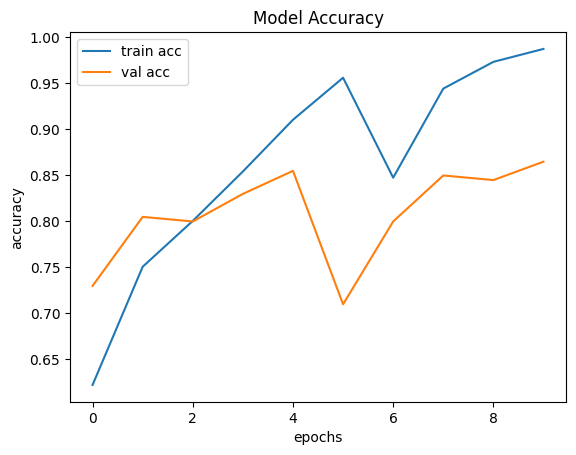

In [58]:
#plot accuracy
import keras
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train acc', 'val acc'], loc='upper left')
plt.show()

#### Model Lost

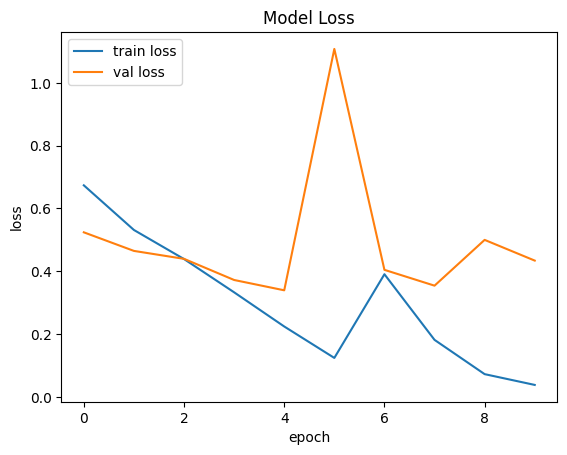

In [59]:
#plot loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

#### Guardamos los pesos del modelo

In [60]:
#Guardamos los pesos del modelo
cnn_lstm_model.save_weights('pesos_cnn_lstm_rentrenado1.weights.h5')

#Guardamos el modelo completo
cnn_lstm_model.save('modelo_cnn_lstm_rentrenado1.keras')

#### Función: Reporte Métricas - Matriz confusión - Guardar predicciones en dataframe

In [62]:
#Función para calcular la PREDICCION con el modelo entrenado usando el conjunto datos testing
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics

def reporte_clasificacion(model,test_padded,Y_test):
  model = model
  y_actuals = np.argmax(Y_test, axis=1) # Convertir Y_test a etiquetas

  #encoder.inverse_transform(a)
  y_preds = model.predict(test_padded)

  prediction_ = np.argmax(y_preds, axis=1) #Convertir predicciones a etiquetas

  y_preds = prediction_
  target_names = ['0', '1']
  report = classification_report(y_actuals.tolist(), y_preds.tolist(), target_names=target_names)
  print("Reporte de métricas")
  print(report)
  print("accuracy: {:0.3f}".format(metrics.accuracy_score(y_actuals.tolist(), y_preds.tolist())))

  #Calcular la matriz de confusión
  cm = confusion_matrix(y_actuals, prediction_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

  #Visualizar y guardar la matriz de confusión
  disp.plot(cmap='Blues')
  plt.title("Matriz de confusión - Testing")
  plt.savefig("Matriz_confusion_testing.png")
  plt.show()

  #Decodificar las secuencias vectorizadas de los textos a los textos originales
  X_test_texts = [' '.join(tokenizer.index_word.get(word, '') for word in sequence if word !=0) for sequence in test_padded]

  #Crear el dataframe con las predicciones
  df_predictions_cnn_lstm = pd.DataFrame({
      'Texto': X_test_texts,
      'Etiqueta Real': y_actuals,
      'Etiqueta Predicha': prediction_
  }

  )

  #Guardar el dataframe a un archivos csv
  df_predictions_cnn_lstm.to_csv('predictions_testing_cnn_lstm.csv', index=False)
  print("Predicciones guardadas en 'predictions_testing_cnn_lstm.csv'")

  return df_predictions_cnn_lstm

22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 778ms/step
Reporte de métricas
              precision    recall  f1-score   support

           0       0.90      0.75      0.82       351
           1       0.77      0.92      0.84       333

    accuracy                           0.83       684
   macro avg       0.84      0.83      0.83       684
weighted avg       0.84      0.83      0.83       684

accuracy: 0.829


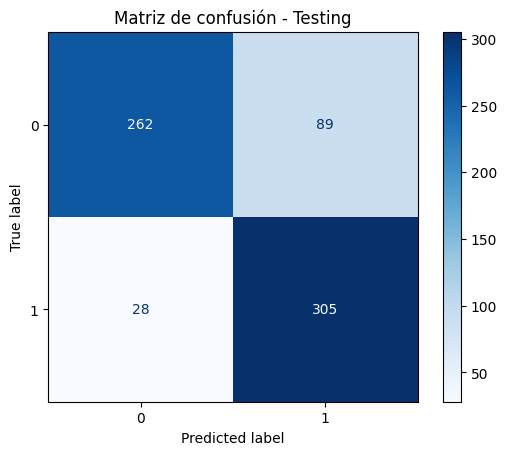

Predicciones guardadas en 'predictions_testing_cnn_lstm.csv'
                                               Texto  Etiqueta Real  \
0  lima sur desde defensoriaperu demandamos respe...              1   
1  elecciones2021 el 10 de febrero es la fecha lí...              1   
2  onpeinforma a partir de ahora compartiremos en...              1   
3  último los titulares del jne la onpeoficial y ...              1   
4  elecciones2021 lescano dice que sube en encues...              1   

   Etiqueta Predicha  
0                  1  
1                  1  
2                  1  
3                  1  
4                  0  


In [63]:
#Resultados
df_resultados_cnn_lstm = reporte_clasificacion(cnn_lstm_model, test_padded, Y_test)
print(df_resultados_cnn_lstm.head())

## Implementación de ajustes en la arquitectura CNN-LSTM

In [65]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [69]:
#Aumentaremos el número de filtros de la capa Conv1D 512
#Agregar capas de Dropout para evitar overfitting

#Se utilizo L2 Regularization en la capa Dense para evitar overfitting
learning_rate=0.001
def CNN_LSTM_model(embedding_matrix):
    emb_dim = embedding_matrix.shape[1]
    cnn_lstm_model = Sequential()
    cnn_lstm_model.add(Embedding(vocab_len, emb_dim, weights=[embedding_matrix]))
    cnn_lstm_model.add(layers.Conv1D(256, kernel_size=3, padding='same', activation='relu'))
    cnn_lstm_model.add(Dropout(0.3))
    cnn_lstm_model.add(layers.MaxPooling1D(pool_size=2))
    cnn_lstm_model.add(LSTM(256, return_sequences=True))
    cnn_lstm_model.add(Dropout(0.3))
    cnn_lstm_model.add(layers.LSTM(256))
    cnn_lstm_model.add(Dense(2, activation='softmax', kernel_regularizer=l2(0.01)))
    cnn_lstm_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    cnn_lstm_model.summary()
    return cnn_lstm_model

In [70]:
cnn_lstm_model = CNN_LSTM_model(embedding_matrix)

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)             │ ?                           │      12,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_12 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_12 (MaxPooling1D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_24 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_25 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,000,000 (45.78 MB)

 Trainable params: 12,000,000 (45.78 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
#Fit the CNN-LSTM model
history = cnn_lstm_model.fit(train_padded, np.asarray(Y_train), validation_data=(val_padded, np.asarray(Y_val)), batch_size = batch_size, epochs = epochs, callbacks=[detener])

Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 672s 51s/step - accuracy: 0.5313 - loss: 1.0043 - val_accuracy: 0.6750 - val_loss: 0.6217
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 705s 54s/step - accuracy: 0.7131 - loss: 0.6048 - val_accuracy: 0.8000 - val_loss: 0.5128
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 699s 51s/step - accuracy: 0.7684 - loss: 0.5341 - val_accuracy: 0.7800 - val_loss: 0.4791
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 686s 51s/step - accuracy: 0.8118 - loss: 0.4453 - val_accuracy: 0.7700 - val_loss: 0.5242
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 664s 50s/step - accuracy: 0.8371 - loss: 0.4040 - val_accuracy: 0.8150 - val_loss: 0.4257
Epoch 5: early stopping


In [72]:
#RESULTADOS
print("Obtained results with CNN-LSTM Model")
train_test_accuracy(cnn_lstm_model, train_padded, Y_train, test_padded, Y_test)

Obtained results with CNN-LSTM Model
Train accuracy: 89.36
Test accuracy: 82.16


In [73]:
#Agregar capas de Dropout para evitar overfitting
#Se utilizo L2 Regularization en la capa Dense para evitar overfitting
learning_rate=0.001
def CNN_LSTM_model(embedding_matrix):
    emb_dim = embedding_matrix.shape[1]
    cnn_lstm_model = Sequential()
    cnn_lstm_model.add(Embedding(vocab_len, emb_dim, weights=[embedding_matrix]))
    cnn_lstm_model.add(layers.Conv1D(256, kernel_size=3, padding='same', activation='relu'))
    cnn_lstm_model.add(Dropout(0.3))
    cnn_lstm_model.add(layers.MaxPooling1D(pool_size=2))
    cnn_lstm_model.add(LSTM(256, return_sequences=True))
    cnn_lstm_model.add(Dropout(0.3))
    cnn_lstm_model.add(layers.LSTM(256))
    cnn_lstm_model.add(Dense(2, activation='softmax', kernel_regularizer=l2(0.01)))
    cnn_lstm_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    cnn_lstm_model.summary()
    return cnn_lstm_model

In [74]:
cnn_lstm_model = CNN_LSTM_model(embedding_matrix)

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)             │ ?                           │      12,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_13 (MaxPooling1D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_26 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_27 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,000,000 (45.78 MB)

 Trainable params: 12,000,000 (45.78 MB)

 Non-trainable params: 0 (0.00 B)

In [75]:
#Fit the CNN-LSTM model
history = cnn_lstm_model.fit(train_padded, np.asarray(Y_train), validation_data=(val_padded, np.asarray(Y_val)), batch_size = batch_size, epochs = epochs, callbacks=[detener])

Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 206s 15s/step - accuracy: 0.5881 - loss: 0.7043 - val_accuracy: 0.7950 - val_loss: 0.5089
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 192s 14s/step - accuracy: 0.7684 - loss: 0.5410 - val_accuracy: 0.7700 - val_loss: 0.4827
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 200s 14s/step - accuracy: 0.8057 - loss: 0.4540 - val_accuracy: 0.7800 - val_loss: 0.4944
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 205s 14s/step - accuracy: 0.8370 - loss: 0.3967 - val_accuracy: 0.8150 - val_loss: 0.4452
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 183s 14s/step - accuracy: 0.8839 - loss: 0.3056 - val_accuracy: 0.8700 - val_loss: 0.3812
Epoch 5: early stopping


In [76]:
#RESULTADOS
print("Obtained results with CNN-LSTM Model")
train_test_accuracy(cnn_lstm_model, train_padded, Y_train, test_padded, Y_test)

Obtained results with CNN-LSTM Model
Train accuracy: 93.32
Test accuracy: 82.75


## Un último ajuste a mi arquitectura inicial

In [77]:
import tensorflow as tf
import numpy as np

In [78]:
def cyclic_lr(epoch, lr):
  base_lr = 1e-4
  max_lr = 1e-3
  step_size = 4

  cycle = np.floor(1 + epoch/(2*step_size))
  x = np.abs(epoch / step_size - 2 * cycle + 1)
  new_lr = base_lr + (max_lr - base_lr)*max(0, (1 - x))

  return new_lr

In [79]:
#Agregar un callback para ajustar el learning_rate en cada epoch

clr_callback = tf.keras.callbacks.LearningRateScheduler(cyclic_lr)

In [80]:
#Entrenamiento del modelo con el nuevo learning rate usando Cyclic Learning
history = cnn_lstm_model.fit(train_padded, np.asarray(Y_train), validation_data=(val_padded, np.asarray(Y_val)), batch_size = batch_size, epochs = epochs, callbacks=[clr_callback])

Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 198s 15s/step - accuracy: 0.9263 - loss: 0.2246 - val_accuracy: 0.8750 - val_loss: 0.3619 - learning_rate: 1.0000e-04
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 189s 14s/step - accuracy: 0.9354 - loss: 0.2091 - val_accuracy: 0.8700 - val_loss: 0.3627 - learning_rate: 3.2500e-04
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 200s 14s/step - accuracy: 0.9434 - loss: 0.1861 - val_accuracy: 0.8950 - val_loss: 0.3263 - learning_rate: 5.5000e-04
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 205s 14s/step - accuracy: 0.9615 - loss: 0.1454 - val_accuracy: 0.8950 - val_loss: 0.3317 - learning_rate: 7.7500e-04
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 199s 14s/step - accuracy: 0.9647 - loss: 0.1295 - val_accuracy: 0.8950 - val_loss: 0.3171 - learning_rate: 0.0010
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 187s 14s/step - accuracy: 0.9503 - loss: 0.1703 - val_accuracy: 0.8600 - val_loss: 0.3577 - learning_rate: 7.7500e-04
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 201s 14s/step - accuracy: 0.97

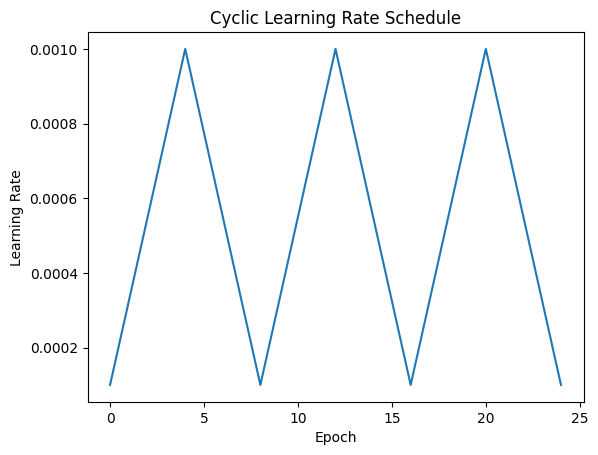

In [84]:
#Visualizar como varia el learning_rate durante el entrenamiento

lrs = history.history['learning_rate']
plt.plot(lrs)
plt.title('Cyclic Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()

In [85]:
#Claves exactas que se podra usar para acceder a las métricas y al learning_rate
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


In [86]:
#RESULTADOS
print("Obtained results with CNN-LSTM Model")
train_test_accuracy(cnn_lstm_model, train_padded, Y_train, test_padded, Y_test)

Obtained results with CNN-LSTM Model
Train accuracy: 99.65
Test accuracy: 82.31


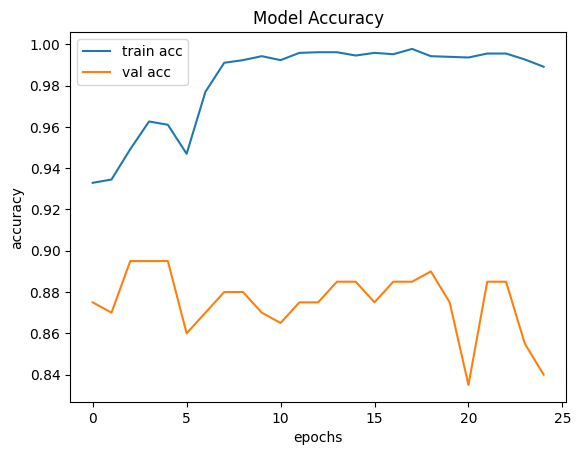

In [87]:
#plot accuracy
import keras
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train acc', 'val acc'], loc='upper left')
plt.show()

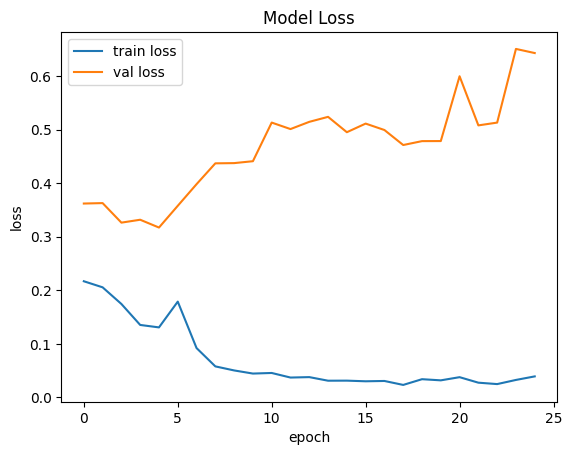

In [88]:
#plot loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()